In [1]:
import os

import numpy as np
import pandas as pd
import scanpy as sc
import torch
import matplotlib.pyplot as plt

from procyon.data.constants import CANONICAL_SPLITS
from procyon.data.data_utils import (
    load_aaseq_embeddings,
    DATA_DIR,
)

## Load data

In [2]:
emb_dir = os.path.join(
    DATA_DIR,
    "generated_data",
    "aa_embeddings",
)

proc_dir = os.path.join(
    DATA_DIR,
    "integrated_data",
    "v1",
)

# Replace with the path where you downloaded a pre-trained ProCyon model (e.g. ProCyon-Full)
checkpoint_path = "~/storage/Lab/PLM/huggingface_repos/ProCyon-Full"
CKPT_NAME = os.path.expanduser(checkpoint_path)


In [3]:
# Protein index
pid = (
        pd.read_pickle(os.path.join(
        proc_dir,
        "protein",
        "protein_info_filtered.pkl",
    ))
    .assign(seq_id=lambda x: x["index"])
    .set_index("index")
)
pid.head()

,protein_id,name,entry,comments,seq_id
index,,,,,
0,P31946,YWHAB,1433B_HUMAN,['FUNCTION: Adapter protein implicated in the ...,0
1,P62258,YWHAE,1433E_HUMAN,['FUNCTION: Adapter protein implicated in the ...,1
2,Q04917,YWHAH,1433F_HUMAN,['FUNCTION: Adapter protein implicated in the ...,2
3,P61981,YWHAG,1433G_HUMAN,['FUNCTION: Adapter protein implicated in the ...,3
4,P31947,SFN,1433S_HUMAN,['FUNCTION: Adapter protein implicated in the ...,4


## Load embeddings

### Retrieve Embeddings before multimodal phenotype learning

In [4]:
protein_seq_embeddings_root = os.path.join(
    DATA_DIR,
    "generated_data",
    "node_embeddings",
    "protein",
)
protein_seq_embeddings_path = os.path.join(protein_seq_embeddings_root, "protein_esm2-3b_mean.pt")
protein_seq_embeddings_idmap_path = os.path.join(protein_seq_embeddings_root, "protein_esm2-3b_mean.pkl")

esm_embeddings = load_aaseq_embeddings(
    protein_seq_embeddings_path,
    protein_seq_embeddings_idmap_path,
    aaseq_type='protein',
)


### Retrieve Embeddings after multimodal phenotype learning

In [5]:
with open(os.path.join(CKPT_NAME, "protein_target_embeddings.pkl"), "rb") as fh:
    procyon_embeds, _ = torch.load(fh)

In [6]:
# Save embeddings and their info
emb = {
    "ESM-2": esm_embeddings.numpy(),
    "ProCyon": procyon_embeds.float().numpy(),
}

## Load protein phenotypes

In [7]:
# Load relations used for training/eval
want_datasets = [
    "drugbank",
    "ec",
    "go",
    "reactome",
    "gtop",
]

rels={}
for db_name in want_datasets:
    path = os.path.join(
        proc_dir,
        f"protein_{db_name}",
        CANONICAL_SPLITS[db_name],
        f"protein_{db_name}_relations_indexed.unified.csv",
    )
    rels[db_name] = pd.read_csv(path)

In [8]:
# Define seq groups - text_id or the 2nd interacting protein
for db, rel in rels.items():
    rel["seq_group"] = rel["text_id" if "text_id" in rel.columns else "seq_id_2"]
    rel.rename({"seq_id_1": "seq_id"}, axis=1, inplace=True)

# Generate UMAP and plot

In [9]:
adatas = {}

for emb_name, emb_sub in emb.items():
    adata = sc.AnnData(emb_sub)

    sc.pp.scale(adata)
    sc.pp.pca(adata, n_comps=30)
    sc.pp.neighbors(adata, n_pcs=30)
    sc.tl.umap(adata)
    adatas[emb_name] = adata

drugbank 176
ec 218
go 461
reactome 2046
gtop 46
drugbank 176
ec 218
go 461
reactome 2046
gtop 46


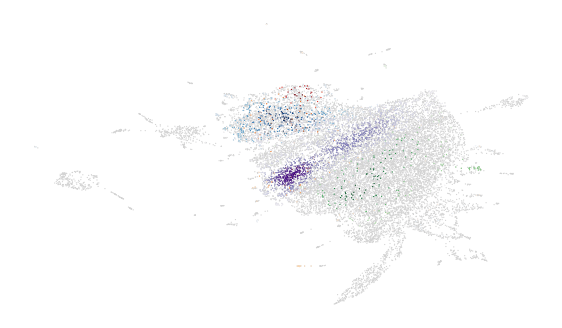

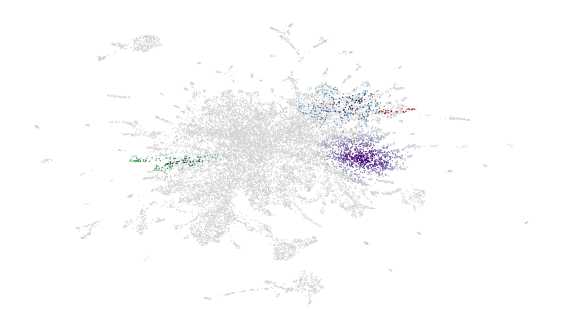

In [10]:
np.random.seed(42)

colors = [
    "Oranges",
    "Greens",
    "Blues",
    "Purples",
    "Reds",
]

for emb_name in ["ESM-2", "ProCyon"]:
    fig, ax = plt.subplots(figsize=(7, 4))
    for i, (db, cmap) in enumerate(zip(want_datasets, colors)):
        df_counts = rels[db].seq_group.value_counts().to_frame()
        list_counts = df_counts.index

        adata = adatas[emb_name]
        example_item = list_counts[1]
        want_items = rels[db].query("seq_group == @example_item").seq_id.unique()
        print(db, len(want_items))

        annotated = np.full(adata.shape[0], False)
        annotated[want_items] = True
        adata.obs[example_item] = annotated
        adata_sub = adata[adata.obs[example_item], :].copy()

        sc.tl.embedding_density(adata_sub, basis="umap")
        # Only plot the full data once

        if i == 0:
            sc.pl.embedding(adata, "X_umap", ax=ax, s=3, show=False, frameon=False)
        sc.pl.embedding_density(
            adata_sub,
            basis="umap",
            key="umap_density",
            ax=ax,
            color_map=cmap,
            show=False,
            frameon=False,
            fg_dotsize=3,
            bg_dotsize=2,
        )

    for item in ax.collections:
        if item.colorbar is not None:
            item.colorbar.remove()